In [19]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('../datasets/hbase-0.94.0.csv')

df.head()

,File,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,...,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE,HeuBug,HeuBugCount,RealBug,RealBugCount
0,security/src/main/java/org/apache/hadoop/hbase...,6,21,487,12,0,1,2,69,4,...,1.0000,1.0,0,1,1,0,False,0,True,1
1,security/src/main/java/org/apache/hadoop/hbase...,0,8,118,6,0,1,0,15,2,...,1.0000,1.0,0,1,1,0,False,0,False,0
2,security/src/main/java/org/apache/hadoop/hbase...,2,12,412,10,0,1,2,46,2,...,1.0000,1.0,0,1,1,0,False,0,False,0
3,security/src/main/java/org/apache/hadoop/hbase...,9,18,737,21,3,2,8,122,4,...,0.9729,0.8,0,1,2,2,False,0,False,0
4,security/src/main/java/org/apache/hadoop/hbase...,0,4,84,2,2,1,0,6,1,...,1.0000,1.0,0,1,1,0,False,0,False,0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 70 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   File                       1059 non-null   object 
 1   CountDeclMethodPrivate     1059 non-null   int64  
 2   AvgLineCode                1059 non-null   int64  
 3   CountLine                  1059 non-null   int64  
 4   MaxCyclomatic              1059 non-null   int64  
 5   CountDeclMethodDefault     1059 non-null   int64  
 6   AvgEssential               1059 non-null   int64  
 7   CountDeclClassVariable     1059 non-null   int64  
 8   SumCyclomaticStrict        1059 non-null   int64  
 9   AvgCyclomatic              1059 non-null   int64  
 10  AvgLine                    1059 non-null   int64  
 11  CountDeclClassMethod       1059 non-null   int64  
 12  AvgLineComment             1059 non-null   int64  
 13  AvgCyclomaticModified      1059 non-null   int64

In [21]:
df.shape

(1059, 70)

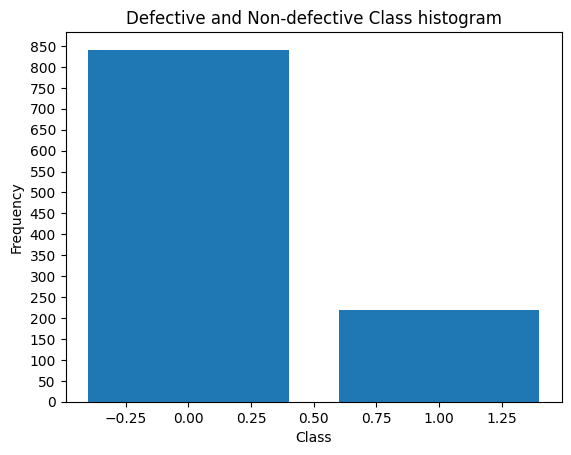

In [22]:
#Defective and Non-defective Class histogram
import matplotlib.pyplot as plt

# Count the occurrences of each class
class_counts = df['RealBug'].value_counts()

# Plot the histogram
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Defective and Non-defective Class histogram')
plt.xticks(rotation=0)
# show more numbers in frequency (y axis)
plt.gca().set_yticks(range(0, class_counts.max() + 50, 50))
# show the grid
# plt.grid(axis='y')
plt.show()


In [23]:
class_counts

RealBug
False    841
True     218
Name: count, dtype: int64

<Axes: xlabel='RealBug', ylabel='CountLineCode'>

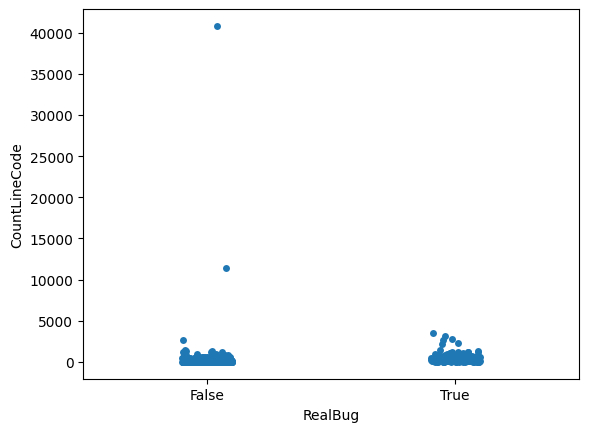

In [24]:
# Dispersion plot of class Defective
import seaborn as sns

sns.stripplot(x='RealBug', y='CountLineCode', data=df, jitter=True)

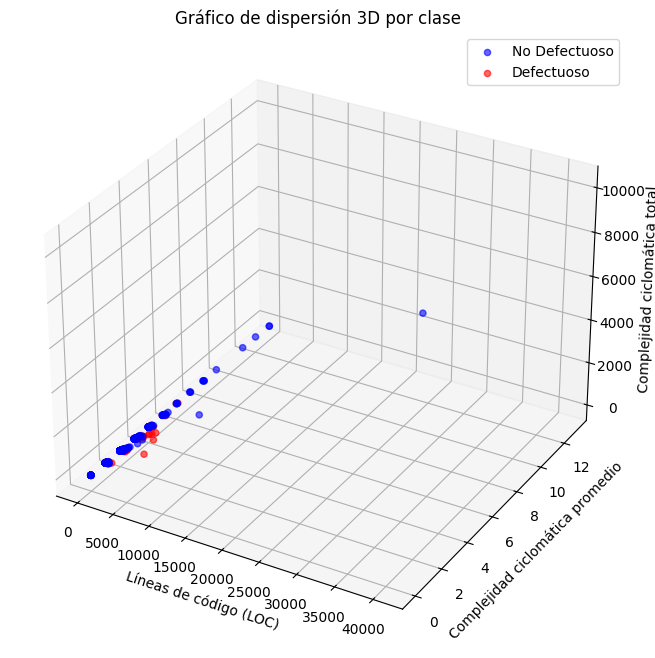

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

# Separar por clase
defective = df[df['RealBug'] == 1]
non_defective = df[df['RealBug'] == 0]

# Graficar cada clase con diferente color
ax.scatter(non_defective['CountLineCode'], 
           non_defective['AvgCyclomatic'], 
           non_defective['SumCyclomatic'],
           c='blue', label='No Defectuoso', alpha=0.6)

ax.scatter(defective['CountLineCode'], 
           defective['AvgCyclomatic'], 
           defective['SumCyclomatic'],
           c='red', label='Defectuoso', alpha=0.6)

ax.set_xlabel('Líneas de código (LOC)')
ax.set_ylabel('Complejidad ciclomática promedio')
ax.set_zlabel('Complejidad ciclomática total')
ax.set_title('Gráfico de dispersión 3D por clase')
ax.legend()

plt.show()

## Preprocesamiento

- isNull / Missing values
- Duplicados
- Outlaiers ( no porque el metodo HCBOU de balanceo no lo recomienda)
- Particion Train/Test
- Transformación de los datos - Normalización/Estandarización (StandarScaler)
- Balanceo de clases - HCBOU
- Seleccion de caracteristicas (arbol de decision - CABOOST) 
- Reduccion de Dimensionalidad (PCA)

### Missing Values

In [26]:
df.isnull().sum()

File                      0
CountDeclMethodPrivate    0
AvgLineCode               0
CountLine                 0
MaxCyclomatic             0
                         ..
MAJOR_LINE                0
HeuBug                    0
HeuBugCount               0
RealBug                   0
RealBugCount              0
Length: 70, dtype: int64

### Duplicated

In [27]:
df.duplicated().sum()

np.int64(0)

### Split Train/Test 80/20

In [28]:
# split train and test
from sklearn.model_selection import train_test_split

X = df.drop(columns=['RealBug'])
y = df['RealBug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
print(X_train.shape)
print(X_test.shape)

(847, 69)
(212, 69)


### Normalización

In [30]:
from sklearn.preprocessing import StandardScaler

X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
X_train_numeric_scaled = pd.DataFrame(scaler.fit_transform(X_train_numeric), columns=X_train_numeric.columns)

In [31]:
X_train_numeric.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE,HeuBugCount,RealBugCount
count,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,...,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000,847.000000
mean,1.845336,9.846517,302.400236,5.017710,1.151122,1.175915,3.154664,35.697757,1.935065,13.501771,...,109.102715,50.208973,0.835330,0.715594,0.037780,1.879575,1.793388,1.131051,0.129870,0.716647
std,4.475404,8.769847,648.790347,5.061178,4.370633,0.574054,9.179890,119.913762,1.303491,11.396971,...,285.398954,178.594897,0.191867,0.302796,0.358601,1.150453,1.184436,1.537726,0.689086,2.071989
min,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.227273,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,81.000000,1.000000,0.000000,1.000000,0.000000,6.000000,1.000000,6.000000,...,4.000000,0.000000,0.712685,0.500000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,8.000000,154.000000,3.000000,0.000000,1.000000,1.000000,13.000000,2.000000,10.000000,...,12.000000,2.000000,0.926702,0.666667,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000
75%,2.000000,13.000000,313.500000,7.000000,0.000000,1.000000,3.000000,33.500000,2.000000,17.000000,...,93.500000,20.000000,1.000000,1.000000,0.000000,2.000000,2.000000,2.000000,0.000000,0.000000
max,53.000000,70.000000,14533.000000,45.000000,57.000000,8.000000,169.000000,3061.000000,13.000000,119.000000,...,3184.000000,2469.000000,1.000000,1.000000,5.000000,9.000000,7.000000,9.000000,10.000000,18.000000


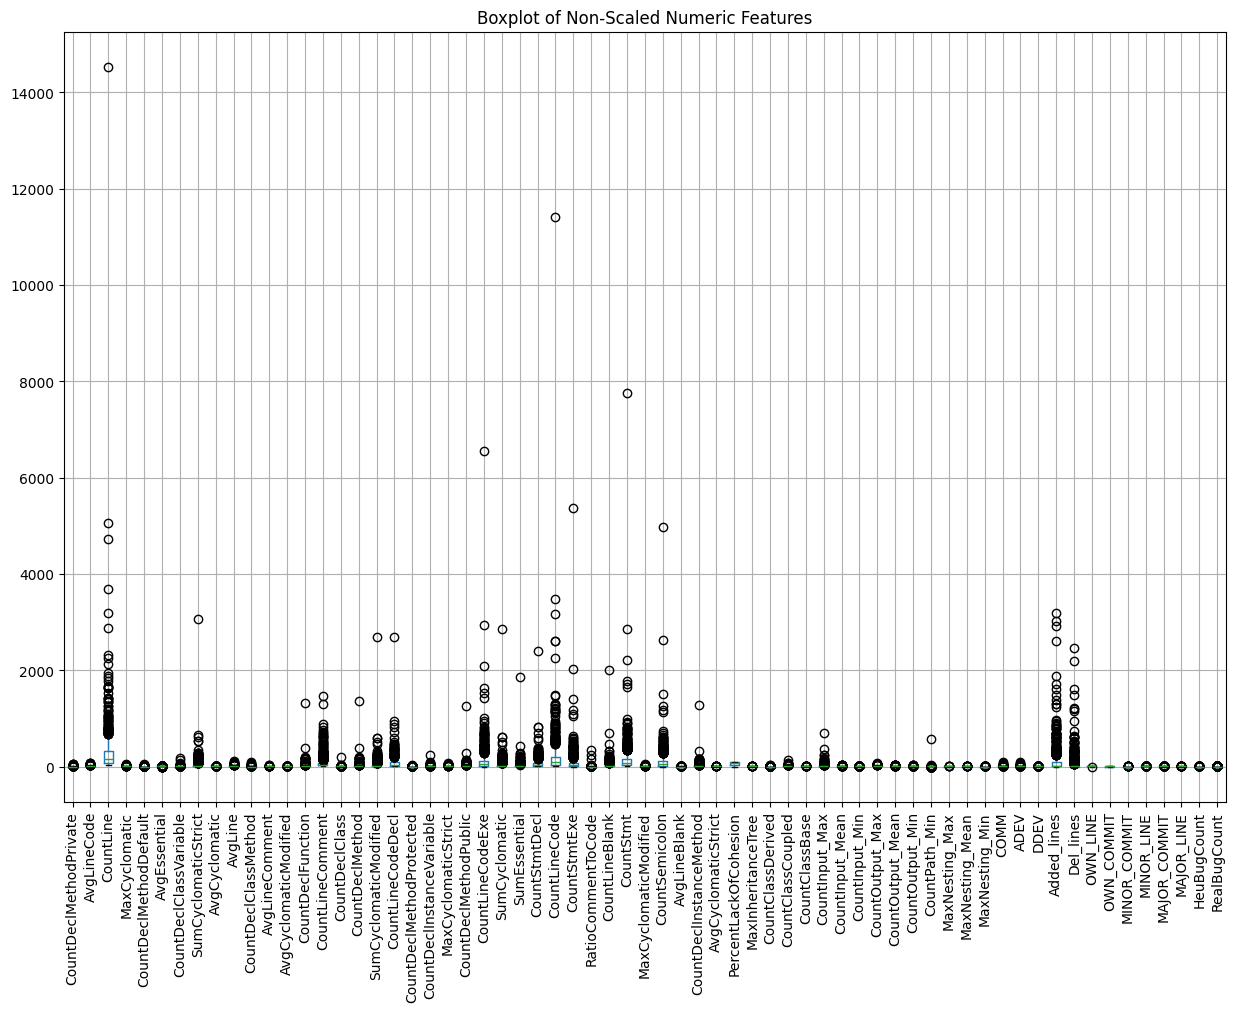

In [32]:
plt.figure(figsize=(15, 10))
X_train_numeric.drop(columns=['CountPath_Max', 'CountPath_Mean']).boxplot()
plt.title('Boxplot of Non-Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [33]:
X_train_numeric_scaled.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE,HeuBugCount,RealBugCount
count,8.470000e+02,8.470000e+02,8.470000e+02,8.470000e+02,8.470000e+02,8.470000e+02,8.470000e+02,8.470000e+02,8.470000e+02,8.470000e+02,...,8.470000e+02,8.470000e+02,8.470000e+02,8.470000e+02,8.470000e+02,8.470000e+02,8.470000e+02,8.470000e+02,8.470000e+02,8.470000e+02
mean,4.194467e-18,-6.291701e-17,5.033361e-17,9.647274e-17,4.613914e-17,-6.711147e-17,1.939941e-17,1.677787e-17,-1.153478e-16,-7.654903e-17,...,2.097234e-17,-1.258340e-17,-3.733076e-16,-1.274069e-16,-4.404191e-17,-3.250712e-17,-3.670159e-17,6.501424e-17,2.516680e-17,8.388934e-18
std,1.000591e+00,1.000591e+00,1.000591e+00,1.000591e+00,1.000591e+00,1.000591e+00,1.000591e+00,1.000591e+00,1.000591e+00,1.000591e+00,...,1.000591e+00,1.000591e+00,1.000591e+00,1.000591e+00,1.000591e+00,1.000591e+00,1.000591e+00,1.000591e+00,1.000591e+00,1.000591e+00
min,-4.125721e-01,-1.123433e+00,-4.231912e-01,-9.919971e-01,-2.635320e-01,-2.049652e+00,-3.438524e-01,-2.978711e-01,-1.485402e+00,-1.185381e+00,...,-3.825073e-01,-2.812994e-01,-3.171039e+00,-2.364681e+00,-1.054173e-01,-7.649984e-01,-1.515024e+00,-7.359691e-01,-1.885786e-01,-3.460783e-01
25%,-4.125721e-01,-6.670551e-01,-3.414524e-01,-7.942979e-01,-2.635320e-01,-3.066246e-01,-3.438524e-01,-2.478056e-01,-7.177783e-01,-6.586139e-01,...,-3.684835e-01,-2.812994e-01,-6.395982e-01,-7.124306e-01,-1.054173e-01,-7.649984e-01,-6.702409e-01,-7.359691e-01,-1.885786e-01,-3.460783e-01
50%,-4.125721e-01,-2.106773e-01,-2.288689e-01,-3.988995e-01,-2.635320e-01,-3.066246e-01,-2.348543e-01,-1.893958e-01,4.984572e-02,-3.074361e-01,...,-3.404360e-01,-2.700943e-01,4.765083e-01,-1.616805e-01,-1.054173e-01,1.047380e-01,-6.702409e-01,-8.527408e-02,-1.885786e-01,-3.460783e-01
75%,3.457898e-02,3.597949e-01,1.711851e-02,3.918972e-01,-2.635320e-01,-3.066246e-01,-1.685803e-02,-1.833864e-02,4.984572e-02,3.071251e-01,...,-5.470214e-02,-1.692480e-01,8.587623e-01,9.398197e-01,-1.054173e-01,1.047380e-01,1.745419e-01,5.654209e-01,-1.885786e-01,-3.460783e-01
max,1.143693e+01,6.863178e+00,2.194701e+01,7.904466e+00,1.278576e+01,1.189457e+01,1.807683e+01,2.524389e+01,8.493710e+00,9.262159e+00,...,1.078040e+01,1.355145e+01,8.587623e-01,9.398197e-01,1.384590e+01,6.192893e+00,4.398456e+00,5.120286e+00,1.433197e+01,8.346359e+00


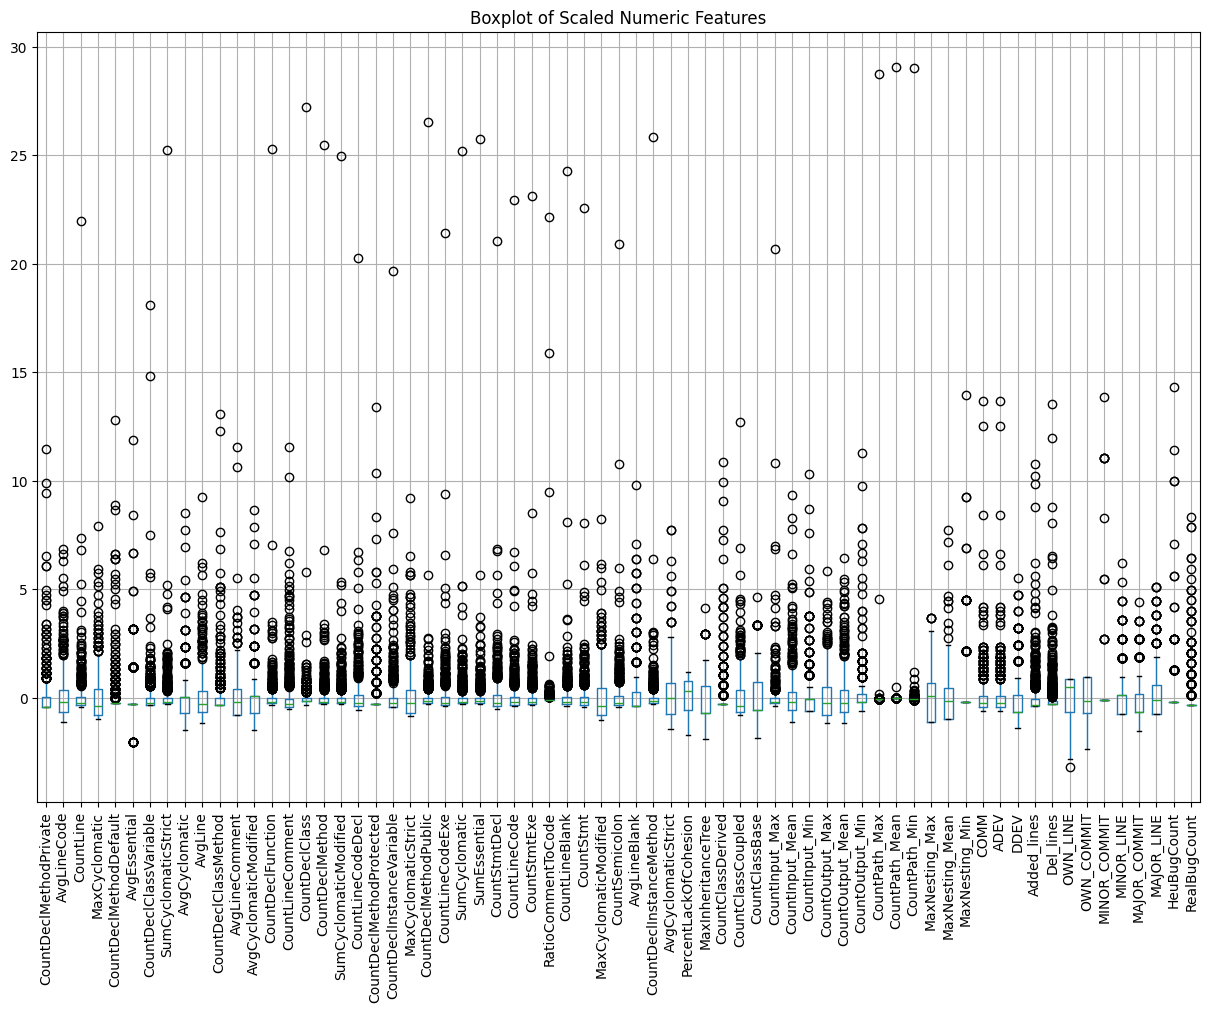

In [34]:
plt.figure(figsize=(15, 10))
X_train_numeric_scaled.boxplot()
plt.title('Boxplot of Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()